# Cargamos el datset
* Importamos la librería para cargar la información previamente scrapeada de Maldita.es.
* 1224 noticias actualmente


In [1]:
import random
import pickle

In [2]:
random.seed(30)

In [3]:
infile = open("Maldita_Dataset_02-07-2020",'rb')
dataset = pickle.load(infile)
len(dataset)

1224

# Realizamos las importaciones
* Librerias para preprocesar los articulos.

In [4]:
# -*- coding: utf-8 -*-
import re, string, unicodedata
import sys
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
from IPython.display import Image
from nltk.tokenize import sent_tokenize

De los diccionarios de articulos me quedo solo con el contenido ['Content'] de x articulos del dataset y los introduzco en una lista de contenidos que se procesará en futuras fases.<br/><br/>
article = {"Title": title, "Publication_date": date, "Content": content, "URL": url, "Fuente": "Maldita.es"}

In [5]:
content_list = []
for a in dataset:
    content_list.append(a['Content'])

In [6]:
print(dataset[43])

{'Title': 'No, esta foto de una mujer abrazando a una agente de policía no ha sido tomada ni en el barrio de Salamanca de Madrid ni durante la crisis del coronavirus: fue en Barcelona en 2017', 'Publication_date': '16/05/2020', 'Content': 'Está circulando una foto en la que una mujer, que lleva una bandera de España, abraza a una agente de policía. Se comparte con mensajes como "Aquí una clara imagen de la policía repartiendo porrazos en el barrio de Salamanca". No obstante, es un bulo que esta imagen haya sido tomada en este barrio madrileño o que sea actual. Fue tomada durante la manifestación a favor de la unidad de España del 8 de octubre de 2017 en Barcelona. La Sexta emitió esta imagen el 8 de octubre de 2017, cuando en la manifestación a favor de la unidad de España de Barcelona algunas personas mostraron su afecto a agentes de la policía. Entre ellas, la imagen del abrazo que ahora circula descontextualizada (min. 00:06 aprox.):', 'URL': 'https://maldita.es/malditob

Funciones para obtener el top 10 de palabras más frecuentes y sus repeticiones.

In [7]:
def get_top_10_keywords(words):
    """
    Return the top10 frequent words.
    :param list word: List containing all the words
    :return: ordered list with the top-10 most frequent words (in descending order)
    :rtype: list
    """
    counts = Counter(words)
    ordered_list = sorted(words, key=counts.get, reverse=True)
    unique_list = []
    
    #10 most common
    most_com = counts.most_common()[0:10]
    
    return most_com
    
    #El codigo de abajo devuelve una lista de tuplas con el numero de repeticiones de cada valor
    #for ol in ordered_list:
    #    if ol not in unique_list:
    #        unique_list.append(ol)
    #return unique_list[:10]

def show_top_10_keywords(processed_articles):
    # Show the top-10 most frequent words
    for article_words in processed_articles:
        # Get te top-10 words
        top_10_words = get_top_10_keywords(article_words)
        
        print("\nTOP 10 words:")
        for el in top_10_words:
            print(el[0], ':', el[1])


def get_top_5_keywords(words):
    """
    Return the top10 frequent words.
    :param list word: List containing all the words
    :return: ordered list with the top-10 most frequent words (in descending order)
    :rtype: list
    """
    counts = Counter(words)
    ordered_list = sorted(words, key=counts.get, reverse=True)
    unique_list = []
    
    #10 most common
    most_com = counts.most_common()[0:5]
    
    return most_com
    
    #El codigo de abajo devuelve una lista de tuplas con el numero de repeticiones de cada valor
    #for ol in ordered_list:
    #    if ol not in unique_list:
    #        unique_list.append(ol)
    #return unique_list[:10]

# Preprocessing

* Sentence segmentation
* Tokenización
* Se realiza la Lemmatizacion de los tokens
* Convierte el texto a minúscula
* Traducción de las tildes
* Quita signos de puntuación (mantiene las tildes)
* Quita las stopwords
* Quita los tokens que tengan valores numéricos
* Extrae las 10 palabras más frecuentes de los artículos

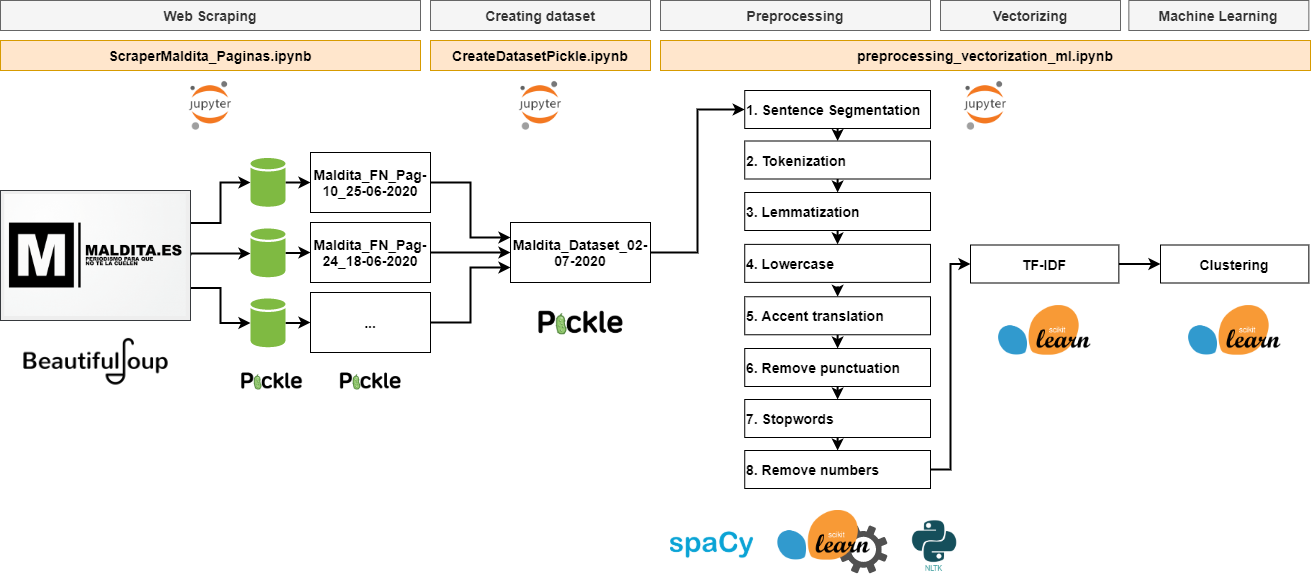

In [8]:
Image(filename='pipeline.png')

Funcion encargada de reemplazar las tildes no reconocidas por el sistema.

In [9]:
def replace_all(str):
    """
    Method used to replace wrong accent characters by good one
    :param dict: dictionary of the character to replace and its replacement (key,value)
    :param str : article that is going to be translated
    :return: string with the accent translated
    """
    dict = {"á":"á", "é":"é", "í":"í", "ó":"ó", "ú":"ú"}
    for key in dict:
        str = str.replace(key, dict[key])
    return str

Función encargada de aplicar el preprocesamiento.

In [10]:
def nlp_articles(articles):
    """
    Preprocessing:
        * Perform some normalization:
            -Convierte el texto a minúscula
            -Traduce las tildes no reconocidas por unas válidas.
            -Quita signos de puntuación (mantiene las tildes)
            -Tokenización de cada artículo (se encuentra incluida en la lemmatización)
            -Se realiza la Lemmatizacion de los tokens
            -Quita las stopwords
            -Extrae las 10 palabras más frecuentes de los artículos
            
    :param list articles: List containing all the news we will process
    :return: list of news tokenized into words
    :rtype: list
    """
    
    tokens_to_remove = []
    tokens_to_remove += stopwords.words('spanish')   #Stopwords from NLTK
    tokens_to_remove += list(STOP_WORDS)             #Stopwords from Spacy
    tokens_to_remove += list(string.punctuation)     #List of puntuations
    tokens_to_remove += ["Noticia", "Noticias", "Parir", "Comer", "Bulo","\r","\n"]  #Custom stopwords
    
    tokens_to_remove = [t.lower() for t in tokens_to_remove] #Lowering the stopwords
    
    #SPACY lemmatizer
    nlp = spacy.load('es_core_news_sm')
    lemmatized_articles = []
    for article in articles:
        print('Processing article number: ', articles.index(article)+1)
        article_words = []
        
        #Sentence segmentation
        for sent in sent_tokenize(article):  
            doc = nlp(sent)
            
            #Tokenization
            for token in doc: 
                current_lemma = token.lemma_   
                current_lemma = current_lemma.lower()                      #Lowercase
                current_lemma = replace_all(current_lemma)                 #Accent translation
                current_lemma = re.sub(r'[^\w\sÀ-ú]', '', current_lemma)   #Remove punctuation
                if (current_lemma not in tokens_to_remove) and (not current_lemma.isdigit()) and (current_lemma != ''):    #Stopwords && not numbers
                    article_words.append(current_lemma)
        lemmatized_articles.append(article_words)
    
    return lemmatized_articles

# Obtengo las keywords
processed_articles = nlp_articles(content_list)

# Muestro las top-10 keywords
show_top_10_keywords(processed_articles)

Processing article number:  1
Processing article number:  2
Processing article number:  3
Processing article number:  4
Processing article number:  5
Processing article number:  6
Processing article number:  7
Processing article number:  8
Processing article number:  9
Processing article number:  10
Processing article number:  11
Processing article number:  12
Processing article number:  13
Processing article number:  14
Processing article number:  15
Processing article number:  16
Processing article number:  17
Processing article number:  18
Processing article number:  19
Processing article number:  20
Processing article number:  21
Processing article number:  22
Processing article number:  23
Processing article number:  24
Processing article number:  25
Processing article number:  26
Processing article number:  27
Processing article number:  28
Processing article number:  29
Processing article number:  30
Processing article number:  31
Processing article number:  32
Processing articl

Processing article number:  262
Processing article number:  263
Processing article number:  264
Processing article number:  265
Processing article number:  266
Processing article number:  267
Processing article number:  268
Processing article number:  269
Processing article number:  270
Processing article number:  271
Processing article number:  272
Processing article number:  273
Processing article number:  274
Processing article number:  275
Processing article number:  217
Processing article number:  277
Processing article number:  278
Processing article number:  279
Processing article number:  280
Processing article number:  281
Processing article number:  282
Processing article number:  283
Processing article number:  284
Processing article number:  285
Processing article number:  286
Processing article number:  287
Processing article number:  288
Processing article number:  289
Processing article number:  290
Processing article number:  291
Processing article number:  292
Processi

Processing article number:  520
Processing article number:  521
Processing article number:  522
Processing article number:  523
Processing article number:  524
Processing article number:  525
Processing article number:  526
Processing article number:  527
Processing article number:  528
Processing article number:  529
Processing article number:  530
Processing article number:  531
Processing article number:  532
Processing article number:  533
Processing article number:  534
Processing article number:  535
Processing article number:  536
Processing article number:  537
Processing article number:  538
Processing article number:  539
Processing article number:  540
Processing article number:  541
Processing article number:  542
Processing article number:  543
Processing article number:  544
Processing article number:  545
Processing article number:  546
Processing article number:  547
Processing article number:  548
Processing article number:  549
Processing article number:  550
Processi

Processing article number:  777
Processing article number:  778
Processing article number:  779
Processing article number:  780
Processing article number:  781
Processing article number:  782
Processing article number:  783
Processing article number:  784
Processing article number:  785
Processing article number:  786
Processing article number:  787
Processing article number:  788
Processing article number:  789
Processing article number:  790
Processing article number:  791
Processing article number:  792
Processing article number:  735
Processing article number:  794
Processing article number:  795
Processing article number:  708
Processing article number:  797
Processing article number:  798
Processing article number:  799
Processing article number:  800
Processing article number:  801
Processing article number:  802
Processing article number:  803
Processing article number:  804
Processing article number:  805
Processing article number:  806
Processing article number:  807
Processi

Processing article number:  1032
Processing article number:  1033
Processing article number:  1034
Processing article number:  1035
Processing article number:  1036
Processing article number:  1037
Processing article number:  1038
Processing article number:  1039
Processing article number:  1040
Processing article number:  1041
Processing article number:  1042
Processing article number:  1043
Processing article number:  1044
Processing article number:  1045
Processing article number:  1046
Processing article number:  1047
Processing article number:  1048
Processing article number:  1049
Processing article number:  1050
Processing article number:  1051
Processing article number:  1052
Processing article number:  1053
Processing article number:  1054
Processing article number:  1055
Processing article number:  1056
Processing article number:  1057
Processing article number:  1058
Processing article number:  1059
Processing article number:  1060
Processing article number:  1061
Processing

explicar : 6
espana : 6
casar : 6

TOP 10 words:
hospital : 10
ingresar : 8
infanta : 5
sofía : 5
ninos : 5
talavera : 5
audio : 4
asegurar : 3
reina : 3
collado : 3

TOP 10 words:
mascarilla : 27
ce : 13
quirúrgicas : 12
gobierno : 9
marcar : 9
deber : 9
venta : 7
cumplir : 7
producto : 7
cartel : 6

TOP 10 words:
imagen : 9
kim : 7
muerte : 4
jongun : 4
montaje : 4
foto : 4
hombre : 3
difundir : 3
sobrar : 3
caro : 3

TOP 10 words:
objetivo : 7
sánchez : 5
gobierno : 4
septiembre : 4
combatir : 4
agenda : 4
web : 3
presidente : 3
gates : 3
pandemia : 3

TOP 10 words:
reembolsar : 5
dato : 5
pedir : 4
enlazar : 4
phishing : 4
banco : 3
santander : 3
contar : 3
casar : 3
mensaje : 3

TOP 10 words:
luis : 24
olmo : 20
espana : 20
programar : 13
frase : 10
otero : 8
salir : 6
protagonistas : 6
julia : 5
empezar : 5

TOP 10 words:
mascarilla : 15
carrefour : 10
preciar : 10
euro : 9
vender : 8
máximo : 8
gobierno : 8
quirúrgicas : 8
higiénicas : 8
abril : 7

TOP 10 words:
afirmar : 4
plas

gárgaras : 3
salar : 3
prevenir : 3
salud : 3

TOP 10 words:
medicamento : 6
ivermectin : 4
investigación : 4
virus : 4
in : 4
vitro : 4
matar : 3
coronavirus : 3
científicos : 3
resultar : 3

TOP 10 words:
bankia : 5
contar : 5
sms : 4
entidad : 4
enlazar : 3
enviar : 3
oficial : 3
seguir : 3
clave : 3
bloquear : 2

TOP 10 words:
correar : 5
inspección : 5
social : 4
enviar : 3
seguridad : 3
investigación : 3
organismo : 3
pedir : 3
enlazar : 3
tratar : 3

TOP 10 words:
whatsapp : 3
enlazar : 3
cadena : 2
secretaría : 2
desarrollo : 2
social : 2
méxico : 2
alimentario : 2
tarjeta : 2
alimento : 2

TOP 10 words:
personar : 9
marzo : 8
espejo : 7
público : 7
respuesta : 6
flaxman : 6
espana : 5
m : 4
emitir : 4
factor : 4

TOP 10 words:
efe : 6
contener : 5
permiso : 4
borrar : 4
retribuir : 3
alarmar : 3
agencia : 3
publicar : 3
noticiar : 3
rectificar : 2

TOP 10 words:
foto : 2
científica : 2
euro : 2
mes : 2
buscar : 2
encontrar : 2
isabel : 2
garcía : 2
tejerina : 2
circular : 1

T

imagen : 3
encontrar : 3
declaración : 3
difundir : 2

TOP 10 words:
respuesta : 6
vídeo : 5
autoinmune : 5
frente : 4
sistema : 4
hemo : 4
sexual : 3
beneficioso : 3
mejorar : 3
enfermedad : 3

TOP 10 words:
cuestionario : 4
preguntar : 3
fundación : 3
covid19 : 2
información : 2
relacionar : 2
coronavirus : 2
edad : 2
código : 2
postal : 2

TOP 10 words:
denunciar : 9
imputar : 7
pedro : 5
sánchez : 5
personar : 5
documentar : 4
juez : 4
mostrar : 3
valladares : 3
marzo : 3

TOP 10 words:
positivo : 9
covid19 : 7
convocar : 6
constitución : 5
rey : 5
calvo : 5
presidente : 4
vicepresidente : 4
catástrofe : 4
disolver : 4

TOP 10 words:
hospital : 13
máscara : 12
máscaras : 9
paciente : 9
esnórquel : 6
explicar : 6
decathlon : 5
utilizar : 5
oficial : 5
respectar : 5

TOP 10 words:
coronavirus : 29
brotar : 8
contar : 8
covid19 : 7
virus : 7
causar : 6
afirmar : 6
vacuno : 5
cepa : 5
china : 5

TOP 10 words:
hospital : 4
puerta : 4
hierro : 4
plantar : 4
reservar : 3
prueba : 2
ingres

cadena : 2
médico : 2
zhong : 2

TOP 10 words:
ley : 6
personar : 5
multar : 4
alarmar : 4
real : 3
actividad : 3
artículo : 3
autoridad : 3
falso : 2
comunicar : 2

TOP 10 words:
policía : 4
nacional : 4
orden : 3
domiciliario : 2
permanecer : 2
hogar : 2
comunidad : 2
madrid : 2
sellar : 2
comunicar : 2

TOP 10 words:
fibrosis : 7
infección : 5
coronavirus : 4
nadar : 4
llinás : 3
pulmón : 3
desmentir : 3
personar : 3
tomar : 3
aguantar : 3

TOP 10 words:
the : 10
to : 7
that : 6
going : 6
spanish : 4
county : 4
málaga : 4
in : 3
council : 3
of : 3

TOP 10 words:
coronavirus : 7
prevenir : 5
recomendación : 4
animal : 4
alimentar : 3
oms : 3
evitar : 3
consumir : 3
sobrar : 2
tomar : 2

TOP 10 words:
espana : 3
diputación : 3
málaga : 3
drones : 3
ejército : 2
pulverizar : 2
helicóptero : 2
municipio : 2
contar : 2
desmentir : 2

TOP 10 words:
ciudad : 3
drones : 3
imagen : 2
social : 2
noche : 2
casar : 2
helicópteros : 2
distinto : 2
ministerio : 2
utilizar : 2

TOP 10 words:
hospi

whatsapp : 4
jaki : 4
mensaje : 4
circular : 4
personar : 3
chino : 3
mujer : 3
contar : 3
enviar : 3
sobrar : 3

TOP 10 words:
imagen : 7
supermercado : 6
hofer : 4
hombre : 3
fotografiar : 3
tomar : 3
foto : 3
mediar : 3
austriaco : 3
coronavirus : 2

TOP 10 words:
musulmán : 26
ayudar : 24
religión : 14
refugiar : 13
personar : 8
país : 7
existir : 7
oficial : 7
social : 6
población : 6

TOP 10 words:
quaden : 15
bayles : 11
año : 9
to : 9
niño : 8
the : 7
australiano : 6
i : 6
acondroplasia : 5
bullying : 5

TOP 10 words:
coronavirus : 4
contar : 3
infección : 3
sobrar : 3
oms : 3
cadena : 2
recomendar : 2
tomar : 2
sistema : 2
brotar : 2

TOP 10 words:
madrid : 7
hospital : 6
coronavirus : 6
alcalá : 5
henares : 5
do : 5
capturar : 4
encontrar : 4
ingresar : 4
asegurar : 3

TOP 10 words:
hemo : 4
contener : 3
diario : 3
coronavirus : 3
publicar : 3
noticiar : 3
titular : 3
encontrar : 3
capturar : 3
país : 2

TOP 10 words:
artículo : 11
aparecer : 10
país : 9
coronavirus : 7
publi

publicar : 4
detectar : 3

TOP 10 words:
víctima : 7
guardia : 5
civil : 5
aplicación : 5
enviar : 5
verificación : 5
mensaje : 4
código : 4
sms : 4
atacante : 4

TOP 10 words:
chino : 17
población : 9
españa : 8
usera : 7
sobrar : 6
contar : 6
centro : 6
mayores : 6
gente : 5
perro : 5

TOP 10 words:
ayudar : 20
generalitat : 18
afirmar : 16
familia : 15
vídeo : 9
especificar : 9
recibir : 8
rentar : 8
pagar : 7
personar : 6

TOP 10 words:
restaurante : 8
entrar : 8
gobierno : 7
sánchez : 6
pedro : 4
pablo : 4
iglesias : 4
vídeo : 4
dueno : 3
cartel : 3

TOP 10 words:
cervantes : 7
obrar : 6
palabra : 6
texto : 6
citar : 4
quijote : 4
siglo : 4
miguel : 3
venir : 3
sancho : 3

TOP 10 words:
foto : 3
perea : 3
suponer : 2
médico : 2
francisco : 2
nacer : 2
ciudad : 2
real : 2
investigador : 2
sobrar : 2

TOP 10 words:
encontrar : 5
richard : 4
gere : 4
arrestar : 4
hemo : 4
qanon : 4
domiciliario : 3
actor : 3
texto : 3
compartir : 3

TOP 10 words:
arzobispo : 3
toledo : 3
contener : 2

TOP 10 words:
promoción : 9
reebok : 7
empresa : 6
falso : 6
página : 5
google : 5
adidas : 5
contar : 4
dirección : 4
web : 3

TOP 10 words:
ministerio : 6
interior : 5
ilegal : 3
prueba : 3
comunicar : 3
oficial : 3
cartel : 2
documentar : 2
accionar : 2
enero : 2

TOP 10 words:
aznar : 11
expresidentes : 4
elección : 4
foreign : 4
policy : 4
cincar : 3
presidente : 3
revistar : 3
españa : 3
maría : 2

TOP 10 words:
contener : 5
pedro : 3
sánchez : 3
crear : 3
bromar : 3
publicar : 3
afirmar : 2
colocar : 2
hermanar : 2
sección : 2

TOP 10 words:
foto : 6
i : 6
canguro : 5
to : 5
this : 5
the : 4
photo : 4
australia : 3
do : 3
imagen : 3

TOP 10 words:
bitcoin : 16
sobrar : 6
falso : 6
timar : 5
hormiguero : 5
hablar : 5
real : 5
inversión : 4
artículo : 4
web : 3

TOP 10 words:
vídeo : 13
unidos : 8
españa : 8
imagen : 7
grabar : 7
metro : 6
barcelona : 6
ubicar : 5
supermercado : 5
pagapensiones : 4

TOP 10 words:
mensaje : 5
whatsapp : 5
oscuro : 4
utilizar : 4
phishing : 3
incibe

contar : 4
contener : 4
afirmar : 4
sobrar : 3

TOP 10 words:
mensaje : 4
whatsapp : 4
vueling : 4
enlazar : 3
plaza : 3
gratis : 3
phishing : 3
utilizar : 3
web : 3
suponer : 2

TOP 10 words:
coronavirus : 9
contener : 5
curar : 5
limón : 3
prevenir : 3
infección : 3
contar : 3
anticoagulante : 3
oms : 3
circular : 2

TOP 10 words:
soldar : 3
vídeo : 2
ninos : 2
apuntar : 2
ocurrir : 2
desmentir : 2
templo : 2
volver : 1
preguntar : 1
armar : 1

TOP 10 words:
vídeo : 8
galapagar : 4
evitar : 4
carretero : 3
pablo : 3
iglesias : 3
irene : 3
montero : 3
grabar : 3
guardia : 3

TOP 10 words:
desempleo : 19
prestación : 18
subsidiar : 11
nacionalidad : 10
imagen : 10
espanola : 8
difundir : 7
requisito : 7
afirmar : 7
denegación : 6

TOP 10 words:
pelear : 6
vídeo : 4
terraza : 2
compartir : 2
silla : 2
welcome : 2
fase : 2
piera : 2
publicó : 2
detenido : 2

TOP 10 words:
médicos : 12
comunicar : 11
colegio : 9
ventilación : 8
texto : 8
suponer : 7
paciente : 7
publicación : 6
hemo : 6
s

existir : 6
contar : 6
soldar : 6
alto : 6

TOP 10 words:
tuit : 6
capturar : 5
usuario : 4
tyson : 3
respuesta : 3
social : 2
suponer : 2
boxeador : 2
real : 2
interacción : 2

TOP 10 words:
personar : 19
tratar : 19
víctimas : 11
tráfico : 10
ilegal : 9
humano : 9
espana : 8
llegar : 7
patera : 7
derecho : 7

TOP 10 words:
hitler : 4
biblia : 4
presidente : 3
trump : 3
imagen : 2
comparar : 2
unidos : 2
donald : 2
manir : 2
fotografía : 2

TOP 10 words:
fotografía : 4
trump : 4
presidente : 3
padre : 3
túnicas : 3
foto : 3
unidos : 2
mary : 2
fred : 2
ataviar : 2

TOP 10 words:
test : 5
enlazar : 4
descargar : 4
dispositivo : 4
autoevaluación : 3
covid19 : 3
página : 3
osi : 3
sms : 2
hacerse : 2

TOP 10 words:
barcelona : 6
colau : 5
montcada : 5
alcaldesa : 4
i : 4
reixac : 4
fotografía : 3
plantar : 3
nissan : 3
efe : 3

TOP 10 words:
consulado : 8
ingresar : 7
mínimo : 7
vital : 7
personar : 5
social : 4
cola : 4
marruecos : 4
almería : 4
junio : 4

TOP 10 words:
vídeo : 14
ayuda

In [11]:
print(len(processed_articles))
processed_articles[43]

1224


['circular',
 'foto',
 'mujer',
 'bandera',
 'espana',
 'abrazar',
 'agente',
 'policía',
 'compartir',
 'mensaje',
 'imagen',
 'policía',
 'repartir',
 'porrazo',
 'barrio',
 'salamanca',
 'obstante',
 'imagen',
 'tomar',
 'barrio',
 'madrileno',
 'actual',
 'tomar',
 'manifestación',
 'favor',
 'unidad',
 'espana',
 'octubre',
 'barcelona',
 'sexta',
 'emitió',
 'imagen',
 'octubre',
 'manifestación',
 'favor',
 'unidad',
 'espana',
 'barcelona',
 'personar',
 'mostrar',
 'afectar',
 'agente',
 'policía',
 'imagen',
 'abrazar',
 'circular',
 'descontextualizar',
 'minuto']

In [12]:
print(dataset[43])

{'Title': 'No, esta foto de una mujer abrazando a una agente de policía no ha sido tomada ni en el barrio de Salamanca de Madrid ni durante la crisis del coronavirus: fue en Barcelona en 2017', 'Publication_date': '16/05/2020', 'Content': 'Está circulando una foto en la que una mujer, que lleva una bandera de España, abraza a una agente de policía. Se comparte con mensajes como "Aquí una clara imagen de la policía repartiendo porrazos en el barrio de Salamanca". No obstante, es un bulo que esta imagen haya sido tomada en este barrio madrileño o que sea actual. Fue tomada durante la manifestación a favor de la unidad de España del 8 de octubre de 2017 en Barcelona. La Sexta emitió esta imagen el 8 de octubre de 2017, cuando en la manifestación a favor de la unidad de España de Barcelona algunas personas mostraron su afecto a agentes de la policía. Entre ellas, la imagen del abrazo que ahora circula descontextualizada (min. 00:06 aprox.):', 'URL': 'https://maldita.es/malditob

# Vectorización de los artículos (TF-IDF)

Se realiza la vectorización de los articulos mediante el cálculo del TF-IDF y se aplica una normalización de tipo 'l2' que normaliza los resultados obtenidos para que se encuentren comprendidos entre los valores 0 y 1

In [13]:
vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, norm='l2')
tfidf_matrix = vectorizer.fit_transform(processed_articles)

#TfidfVectorizer ---> Equivalent to CountVectorizer followed by TfidfTransformer.
#idfs are calculated by TfidfTransformer's fit()
#tfidfs are calculated by TfidfTransformer's transform()
#tfs are calculated by CountVectorizer's fit_transform()

matrix_vocab = vectorizer.get_feature_names()
matrix = tfidf_matrix.todense()
#matrix_idf = vectorizer.idf_
print(tfidf_matrix.shape)
#print(matrix_vocab)
print(matrix[43])

(1224, 18428)
[[0. 0. 0. ... 0. 0. 0.]]


In [14]:
#If i want to view the full matrix -> threshold = sys.maxsize
np.set_printoptions(threshold=1000) # sys.maxsize
matrix[43]

matrix([[0., 0., 0., ..., 0., 0., 0.]])

TF IDF mide la "importancia" de las palabras. Palabras que salen mucho tienen el tf idf mas bajo pero tambien lo tienen mas veces porque salen en mas documentos. Por otro lado las que salen menos como "ornitorrinco" tendrian un TF IDF más alto pero único puesto que salen en pocos documentos pero son palabras que caracterizan un documento en concreto

# CLUSTERIZACIÓN

* Clusterización empleando MiniBatchKMeans puesto que su ejecución es mas rápida y los resultados son muy similares al Kmeans.
* Método del codo -> Buscamos el número óptimo de clusters en base al SSE. Nos quedamos con el número de clusters más óptimo y más visual para el análisis.
* Dibujamos los clusters en base al PCA y al TSNE.
* Mostramos el top keywords de cada cluster.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sum of squared errors (SSE) - SSE is the sum of the squared differences between each observation and its group's mean. It can be used as a measure of variation within a cluster. If all cases within a cluster are identical the SSE would then be equal to 0.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


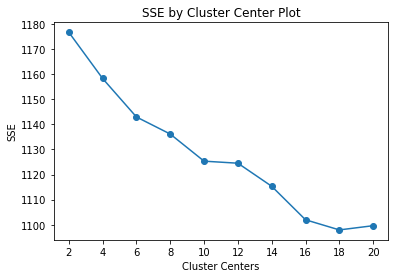

In [16]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

#Using elbow method we select the point that aims to the "elbow"
find_optimal_clusters(tfidf_matrix, 20)

In [17]:
num_of_clusters = 16
clusters = MiniBatchKMeans(n_clusters=num_of_clusters, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_matrix)
print(clusters)

[ 4 10 14 ... 10 10 10]


PCA = análisis de componentes principales : Es un algoritmo de reducción de dimensionalidad que permite la visualización en 2 o 3 dimensiones de conjuntos de datos de un mayor número de dimensiones

TSNE = t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

https://www.interactivechaos.com/manual/tutorial-de-machine-learning/t-sne

t-SNE (T-distributed Stochastic Neighbor Embedding) es un algoritmo diseñado para la visualización de conjuntos de datos de alta dimensionalidad. Si el número de dimensiones es muy alto, Scikit-Learn recomienda en su documentación utilizar un método de reducción de dimensionalidad previo (como PCA) para reducir el conjunto de datos a un número de dimensiones razonable (por ejemplo 50), lo que reducirá el ruido y aligerará la ejecución de t-SNE.

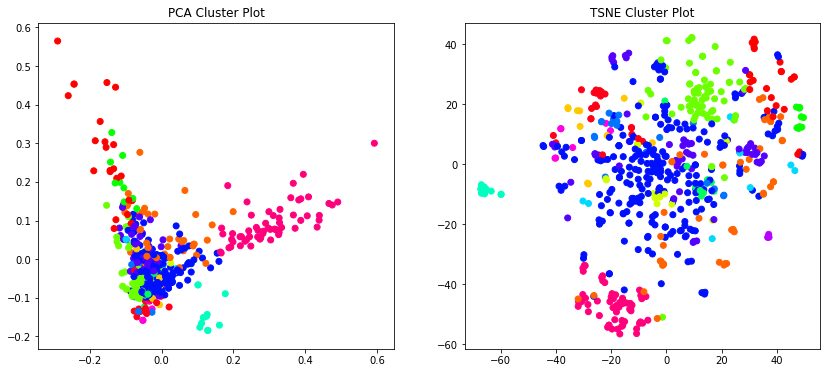

In [18]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    #max_items = np.random.choice(range(data.shape[0]), size=3000, replace=True)
    max_items = np.arange(0, data.shape[0])
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    num_of_nodes = data.shape[0]/2 #Number of dots represented on T-SNE -> default 300, now 612 (half dataset)

    idx = np.random.choice(range(pca.shape[0]), size=int(num_of_nodes), replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
        
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    #print(label_subset)
plot_tsne_pca(tfidf_matrix, clusters)

In [19]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    #display(df)
    #I=Number for row, r=content of dataframe
    cluster_top_words = []
    for i,r in df.iterrows():
        #print(r[3091],r[12670],r[8745],r[4431],r[3192],r[3308],r[17496],r[2607],r[17888],r[4306])
        print('\nCluster {}'.format(i+1))
        #print(np.argsort(r)[-n_terms:])
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        cluster_top_w = [(labels[t],str(r[t])) for t in np.argsort(r)[-5:]] #only top 5 for chart
        #print(cluster_top_w)
        cluster_top_words.append(cluster_top_w)
        
    return cluster_top_words

cluster_top_words = get_top_keywords(tfidf_matrix, clusters, matrix_vocab, 10)
#cluster_top_words

#i->numero de cluster
#r->array de los valores de tf-idf
#t->valor numerico de la palabra en matrix_vocab
#print(matrix_vocab[3091])
#Los valores que imprimo del join salen en sentido "contrario" coronavirus es el de mayor tf idf en teoria

#Cluster 13 - Podcast semanal de maldita
#Cluster 8 - Estafa de bitcoin system
#Cluster 11 - Cluster con todas las noticias - Aplicar clusterización sobre estos articulos


Cluster 1
causar,patentar,humano,covid19,cepa,china,vacuno,brotar,virus,coronavirus

Cluster 2
covid19,sobrar,salud,coronavirus,reenviar,sanidad,cadena,ministerio,mensaje,whatsapp

Cluster 3
totalitario,resolución,políticos,percibir,cifrar,político,europeo,soldar,cargo,diputar

Cluster 4
mascarilla,abril,interior,marzo,decretar,oficial,boe,alarmar,ministerio,documentar

Cluster 5
policía,coronavirus,afirmar,hombre,aparecer,personar,imagen,imágenes,grabar,vídeo

Cluster 6
fibrosis,consumir,contagiar,aguar,recomendación,oms,alimentar,infección,prevenir,coronavirus

Cluster 7
foto,tocar,comunidad,díaz,madrid,cartel,bandera,imagen,montaje,ayuso

Cluster 8
timarte,caro,invertir,programar,conocido,dinero,hormiguero,inversión,timar,bitcoin

Cluster 9
mensaje,contar,año,polla,cáncer,ortega,amancio,actor,porno,jordi

Cluster 10
ataúdes,discursar,legionario,imágenes,presidente,saludar,imagen,gobierno,pedro,sánchez

Cluster 11
tuit,mensaje,afirmar,sobrar,personar,contener,año,publicar,contar,ima

In [20]:
import random
def get_indexes(clusters,dataset, num_of_clusters):
    indexes = []
    for i in range(0,num_of_clusters):
        indexes_aux = np.where(clusters == i)
        indexes.append(list(indexes_aux[0]))
        print('Cluster', i+1,'-', len(indexes_aux[0]), 'articles classified in this cluster')
        for i in indexes_aux:
            #print(type(i), i)
            articulos = random.sample(list(i), k=3)
            print(articulos)
            for a in articulos:
                print(dataset[a]['URL'])
    return indexes
indexes = get_indexes(clusters,dataset, num_of_clusters)
#print(len(clusters),len(dataset), num_of_clusters)


Cluster 1 - 65 articles classified in this cluster
[597, 20, 421]
https://maldita.es/malditobulo/2020/03/05/pdf-patente-coronavirus-sars-covid-19/
https://maldita.es/malditaciencia/2020/05/19/video-virologa-judy-mikovits-coronavirus/
https://maldita.es/malditobulo/2020/03/22/cuba-crea-vacuna-contra-coronavirus-bulo/
Cluster 2 - 84 articles classified in this cluster
[380, 76, 475]
https://maldita.es/malditobulo/2020/03/26/carmen-calvo-coronavirus-muface-siat/
https://maldita.es/malditaciencia/2020/05/07/coronavirus-neumonia-trombosis-atacar/
https://maldita.es/malditobulo/2020/03/17/audio-doctora-coronavirus/
Cluster 3 - 19 articles classified in this cluster
[912, 691, 352]
https://maldita.es/malditobulo/2020/01/15/sueldos-vitalicios-ni-diputados-ni-ministros-ni-vicepresidentes-tienen-derecho-a-ellos/
https://maldita.es/malditobulo/2020/02/18/podemos-rtve-5-consejeros-controla/
https://maldita.es/malditobulo/2020/03/29/no-bruselas-no-ha-pedido-al-gobierno-espanol-que-reduzca-mas-de-40

In [21]:
print(dataset[154])

{'Title': 'No, este no es un documento oficial para la desescalada del estado de alarma por el coronavirus que plantea el Gobierno: es un documento de un economista y plantea su opinión personal', 'Publication_date': '20/04/2020', 'Content': 'Están circulando dos imágenes de una tabla de prevision de fases de desescalada del estado de alarma. Se mueve como una la hoja de ruta propuesta por el Gobierno. No lo es. Estas imágenes han circulado también afirmando que salen de instituciones oficiales como el Ejército, los Mossos d\'Esquadra o de la Junta de Castilla y León. Es un bulo: este documento no aparece en ninguna web oficial y un economista asegura que se trata de un documento propio con su "visión personal", no un documento oficial. En las imágenes que se están difundiendo aparecen dos tablas en las que se establecen 6 fases del estado de alarma. Cada fase establece unos periodos y unas restricciones diferentes. Se están difundiendo afirmando que se trata de una hoja de r

# Cluster 11 - Outlier

El cluster 11 resulta extraño puesto que contiene muchos artículos asique vamos a analizarlo de forma aislada. Para ello, calcularemos de nuevo el TF-IDF y realizaremos de nuevo la clusterización

In [22]:
#Generamos el dataset que contiene los articulos procesados correspondientes.
c11_dataset =[]
for i in indexes[10]:
    c11_dataset.append(dataset[i])
#print(indexes[10])  
#print(c11_dataset)

content_list_c11= []
for a in c11_dataset:
    content_list_c11.append(a['Content'])
print(len(content_list_c11))

processed_articles_c11 = nlp_articles(content_list_c11)

473
Processing article number:  1
Processing article number:  2
Processing article number:  3
Processing article number:  4
Processing article number:  5
Processing article number:  6
Processing article number:  7
Processing article number:  8
Processing article number:  9
Processing article number:  10
Processing article number:  11
Processing article number:  12
Processing article number:  13
Processing article number:  14
Processing article number:  15
Processing article number:  16
Processing article number:  17
Processing article number:  18
Processing article number:  19
Processing article number:  20
Processing article number:  21
Processing article number:  22
Processing article number:  23
Processing article number:  24
Processing article number:  25
Processing article number:  26
Processing article number:  27
Processing article number:  28
Processing article number:  29
Processing article number:  30
Processing article number:  31
Processing article number:  32
Processing ar

Processing article number:  261
Processing article number:  262
Processing article number:  263
Processing article number:  264
Processing article number:  265
Processing article number:  266
Processing article number:  267
Processing article number:  268
Processing article number:  269
Processing article number:  270
Processing article number:  271
Processing article number:  272
Processing article number:  273
Processing article number:  274
Processing article number:  275
Processing article number:  276
Processing article number:  277
Processing article number:  278
Processing article number:  279
Processing article number:  280
Processing article number:  281
Processing article number:  282
Processing article number:  283
Processing article number:  284
Processing article number:  285
Processing article number:  286
Processing article number:  287
Processing article number:  288
Processing article number:  289
Processing article number:  290
Processing article number:  291
Processi

In [23]:
#Vectorizar C11
tfidf_matrix_c11 = vectorizer.fit_transform(processed_articles_c11)

matrix_vocab_c11 = vectorizer.get_feature_names()
matrix_c11 = tfidf_matrix_c11.todense()
#matrix_idf = vectorizer.idf_
print(tfidf_matrix_c11.shape)
#print(matrix_vocab_c11)

(473, 11919)


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


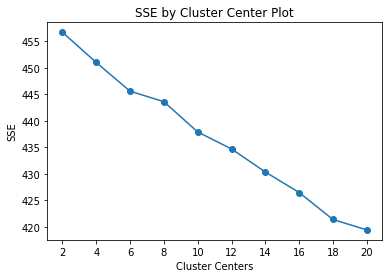

In [24]:
find_optimal_clusters(tfidf_matrix_c11, 20)

In [25]:
num_of_clusters_c11 = 6
clusters_c11 = MiniBatchKMeans(n_clusters=num_of_clusters_c11, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_matrix_c11)
print(clusters_c11)

[4 4 4 4 4 4 4 2 4 4 2 4 4 4 2 4 2 4 2 4 4 1 4 4 1 4 4 4 1 4 4 2 2 4 2 2 1
 4 4 0 4 4 1 4 2 4 4 4 2 4 0 1 4 2 2 2 2 4 2 4 5 4 4 1 4 2 4 1 2 1 1 2 2 4
 4 2 2 4 4 4 4 4 0 4 4 4 3 4 4 4 4 4 1 0 4 4 1 4 4 4 1 2 4 2 4 3 4 4 2 4 2
 4 2 4 2 2 4 4 4 4 4 1 2 4 4 1 4 1 4 4 1 4 4 3 2 4 4 4 4 4 2 4 4 1 2 4 4 4
 5 2 4 4 4 5 2 2 1 2 4 4 1 0 2 2 2 1 2 4 4 4 4 2 4 1 2 4 1 4 4 4 1 2 2 0 0
 2 5 0 5 4 4 0 3 2 2 4 4 4 2 2 0 2 2 4 4 3 2 4 2 2 4 4 0 4 2 4 2 0 2 0 2 2
 2 0 0 0 2 1 2 2 0 2 2 4 4 4 2 5 2 3 2 2 4 4 0 0 3 4 0 3 2 3 4 2 4 4 3 4 0
 0 2 3 4 4 0 3 4 2 4 4 4 4 5 0 3 5 3 2 4 1 2 4 2 4 4 1 4 2 5 1 4 2 0 2 0 2
 2 4 3 0 0 2 2 2 4 2 2 2 2 2 2 0 1 4 4 2 2 5 2 4 2 2 2 4 2 4 0 2 2 2 2 2 5
 4 2 1 2 2 4 4 2 0 2 5 1 4 4 4 2 4 2 3 5 5 5 0 3 0 2 0 4 0 5 2 0 5 2 0 1 0
 5 0 2 0 4 0 5 3 4 4 3 4 2 2 2 5 5 2 5 2 0 1 2 4 2 3 5 2 2 4 2 2 5 2 5 2 4
 0 2 4 4 4 4 4 4 4 3 4 4 0 4 4 4 2 4 4 2 0 4 1 1 3 4 4 4 3 4 2 4 3 4 4 4 3
 4 4 4 4 4 4 4 2 0 1 4 1 4 4 0 4 1 4 1 4 0 2 4 4 4 1 2 4 4]


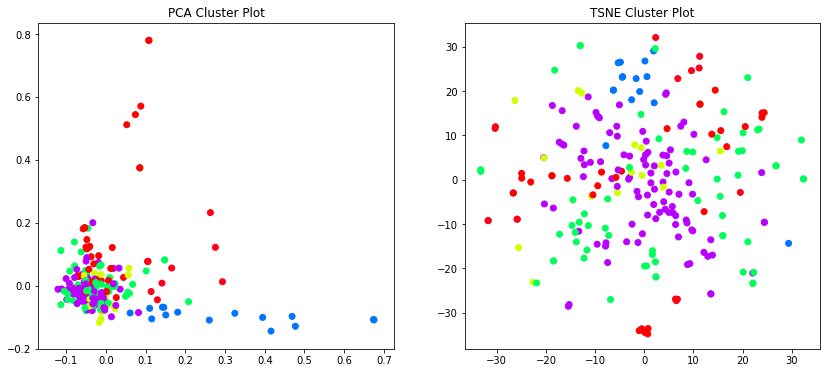

In [26]:
plot_tsne_pca(tfidf_matrix_c11, clusters_c11)

In [27]:
get_top_keywords(tfidf_matrix_c11, clusters_c11, matrix_vocab_c11, 10)


Cluster 1
igualdad,legal,sortear,loterías,bombo,satírico,publicar,real,web,contener

Cluster 2
monteros,espinosa,entrar,folha,gobierno,orgullo,comunidad,respirador,dato,madrid

Cluster 3
publicar,the,twitter,alertar,desmentir,mensaje,tuit,niño,policía,contar

Cluster 4
vital,menor,año,personar,prestación,recibir,mínimo,extranjero,euro,ayudar

Cluster 5
sobrar,aparecer,difundir,gobierno,afirmar,asegurar,foto,personar,coronavirus,imagen

Cluster 6
madre,asesinar,menor,dato,género,hombre,violencia,año,curie,mujer


[[('satírico', '0.047249051459191053'),
  ('publicar', '0.053684810184891435'),
  ('real', '0.05446612246147813'),
  ('web', '0.05896268405815822'),
  ('contener', '0.10882596658523434')],
 [('orgullo', '0.029417607599724605'),
  ('comunidad', '0.031421894922503364'),
  ('respirador', '0.03857787429364297'),
  ('dato', '0.04653105566203082'),
  ('madrid', '0.052146750907271375')],
 [('mensaje', '0.028472475847361563'),
  ('tuit', '0.031871838992385285'),
  ('niño', '0.032658974521590535'),
  ('policía', '0.034784915826591885'),
  ('contar', '0.04878183280109652')],
 [('recibir', '0.0771136484972094'),
  ('mínimo', '0.09479705585820661'),
  ('extranjero', '0.09780068592958817'),
  ('euro', '0.0982835996671207'),
  ('ayudar', '0.15719113921439795')],
 [('asegurar', '0.018113462069863816'),
  ('foto', '0.020216696447193573'),
  ('personar', '0.021148149979757714'),
  ('coronavirus', '0.027329374235494832'),
  ('imagen', '0.03673572331447117')],
 [('hombre', '0.07031316454008879'),
  ('vio

In [58]:
indexes_c11 = get_indexes(clusters_c11,c11_dataset, num_of_clusters_c11)

Cluster 1 - 48 articles classified in this cluster
[258, 259, 39]
https://maldita.es/malditobulo/2020/02/05/no-el-gobierno-no-ha-aprobado-indemnizar-con-4-500-millones-de-euros-a-miembros-del-frap-y-eta-por-su-lucha-antifranquista/
https://maldita.es/malditobulo/2020/02/05/no-el-texto-en-el-que-aznar-supuestamente-dice-haber-hablado-con-dios-y-ser-elegido-para-liderar-la-humanidad-tras-el-atentado-de-eta-no-es-un-extracto-de-sus-memorias-es-una-publicacion-satirica/
https://maldita.es/malditobulo/2020/05/03/gobierno-120-millones-ministerio-igualdad-financiar-charlas-online-transexualidad-alumnos-de-eso-tuit-publico/
Cluster 2 - 40 articles classified in this cluster
[344, 312, 63]
https://maldita.es/malditobulo/2020/01/07/que-sabemos-sobre-el-70-de-extranjeros-en-manadas-de-violadores-3/
https://maldita.es/malditobulo/2020/01/17/que-sabemos-de-los-14-medicos-que-cuidan-a-pedro-sanchez-en-la-moncloa-no-es-algo-nuevo-aprobado-por-este-gobierno-es-un-convenio-de-asistencia-sanitaria-que-i

In [29]:
c11_dataset[386]

{'Title': 'No, no existe ningún dato que avale la cifra de "67 niños muertos a manos de sus madres" ni en 2018 ni en 2019',
 'Publication_date': '14/12/2019',
 'Content': 'Se está difundiendo en redes sociales una imagen que afirma que hay "67 niños muertos a manos de sus madres en lo que va de año". La cifra de 67 niños supuestamente asesinados por sus madres ya se movió a principios de año en distintos formatos y entonces ya os contamos que no había ningún dato que avalase esa afirmación. Con los últimos datos disponibles y publicados por el Instituto Nacional de Estadística (INE), correspondientes al 2018, en España, murieron 20 niños (menores de 14 años) por causas externas que no fueran accidentales o por suicidio. Si se observan las muertes solamente por homicidio, este número baja a 14. Estos homicidios son el total de los registrados, sin distinguir el género del homicida ni su relación con el niño(*).El presidente de la Asociación Profesional de Criminólogos de España (ASPROCR

# CHARTS

In [30]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [31]:
'''
Input indexes: List of cluster that containts list of indexes of articles
Input processed_articles: List of processed articles. Each article contains a list of tokens.
Output: List of terms that appear on each cluster
'''
def cluster_freq_words(indexes,processed_articles):
    cluster_freq_terms = []
    for cluster in range(len(indexes)):
        cluster_words = []
        #print('Cluster', cluster)
        for i in indexes[cluster]: 
            cluster_words += processed_articles[i]
            #print('article', i, 'appended')
        cluster_freq_terms.append(cluster_words)
    return cluster_freq_terms

cluster_freq_terms = cluster_freq_words(indexes,processed_articles)
cluster_freq_terms

[['tasuku',
  'honjo',
  'protagonista',
  'cadena',
  'whatsapp',
  'nobel',
  'medicina',
  'afirmar',
  'coronavirus',
  'natural',
  'fabricar',
  'virus',
  'completamente',
  'artificial',
  'cadena',
  'tasuku',
  'honjo',
  'anos',
  'laboratorio',
  'wuhan',
  'china',
  'origen',
  'contar',
  'twitter',
  'tasukuhonjo',
  'hacía',
  'pasar',
  'honjo',
  'tuiteó',
  'abril',
  'inglés',
  'objetivar',
  'coronar',
  'virus',
  'sic',
  'producir',
  'definitivamente',
  'fabricar',
  'hombre',
  'contar',
  'tasukuhonjo',
  'cambiar',
  'foto',
  'perfil',
  'nombrar',
  'usuario',
  'abril',
  'contar',
  'twitter',
  'representar',
  'opinión',
  'dr',
  'honjo',
  'fuente',
  'información',
  'falso',
  'fraudulento',
  'difamatorio',
  'nombrar',
  'dr',
  'honjo',
  'universidad',
  'solicitar',
  'twitter',
  'desactivación',
  'indicar',
  'malditaes',
  'universidad',
  'kioto',
  'universidad',
  'kioto',
  'publicar',
  'abril',
  'comunicar',
  'tasuku',
  'honjo'

In [32]:
'''
Here i get a list that contains another list that contains a top 5 words with the times that word appears for each cluster
'''
cluster_num = 0  #Bar chart cluster
data2 = [get_top_5_keywords(cluster_freq_terms[i]) for i in range(len(cluster_freq_terms))]
data2

[[('coronavirus', 1871),
  ('contar', 697),
  ('explicar', 519),
  ('virus', 501),
  ('preguntar', 485)],
 [('mensaje', 193),
  ('whatsapp', 178),
  ('ministerio', 165),
  ('coronavirus', 165),
  ('sobrar', 162)],
 [('diputar', 94),
  ('cargo', 68),
  ('político', 62),
  ('cadena', 52),
  ('público', 48)],
 [('documentar', 83),
  ('ministerio', 70),
  ('personar', 57),
  ('gobierno', 56),
  ('oficial', 55)],
 [('vídeo', 928),
  ('grabar', 208),
  ('imagen', 195),
  ('personar', 191),
  ('sobrar', 182)],
 [('coronavirus', 209),
  ('prevenir', 79),
  ('contar', 68),
  ('infección', 65),
  ('cadena', 64)],
 [('imagen', 50),
  ('madrid', 32),
  ('ayuso', 31),
  ('montaje', 27),
  ('comunidad', 26)],
 [('bitcoin', 165),
  ('timar', 104),
  ('falso', 60),
  ('inversión', 59),
  ('hablar', 52)],
 [('contar', 50),
  ('hemo', 44),
  ('difundir', 34),
  ('afirmar', 34),
  ('jordi', 33)],
 [('sánchez', 81),
  ('pedro', 63),
  ('gobierno', 59),
  ('imagen', 52),
  ('publicar', 38)],
 [('contar', 5

In [33]:
#Drawing top 5 most frequent words from each cluster != TF-IDF

figure = make_subplots(rows=4, cols=4)
c_num=0
for rows in range(1,5):
    for cols in range(1,5):
        figure.add_trace(go.Bar(orientation='h',name='Cluster ' + str(c_num+1),x=[el[1] for el in data2[c_num]], y=[el[0] for el in data2[c_num]]), row=rows, col=cols)
        c_num+=1

figure.update_layout(title_text='Top 5 most frequent words from each cluster')
figure.update_yaxes(dict(
        tickmode = 'linear',
        dtick = 1,
        autorange="reversed"
    ))
figure

In [34]:
#Drawing top 5 most important words from each cluster = TF-IDF

figure_tf_idf = make_subplots(rows=4, cols=4)
c_num=0
for rows in range(1,5):
    for cols in range(1,5):
        figure_tf_idf.add_trace(go.Bar(orientation='h',name='Cluster ' + str(c_num+1),x=[el[1] for el in cluster_top_words[c_num]], y=[el[0] for el in cluster_top_words[c_num]]), row=rows, col=cols)
        c_num+=1

figure_tf_idf.update_layout(title_text='Top 5 most important (TF-IDF) words from each cluster')
figure_tf_idf.update_yaxes(dict(
        tickmode = 'linear'
    ))
figure_tf_idf

In [35]:
c_num=7

comparison = make_subplots(rows=1, cols=2)

#frequent
comparison.add_trace(go.Bar(orientation='h',name='Cluster ' + str(c_num+1) + ' - Frequency',x=[el[1] for el in data2[c_num][::-1]], y=[el[0] for el in data2[c_num][::-1]]), row=1, col=1)
#comparison.add_trace(go.Bar(orientation='h',name='Cluster ' + str(c_num+1),x=[el[1] for el in data2[c_num]], y=[el[0] for el in data2[c_num]]), row=1, col=1)

#tf-idf
comparison.add_trace(go.Bar(orientation='h',name='Cluster ' + str(c_num+1) + ' - TF-IDF',x=[el[1] for el in cluster_top_words[c_num]], y=[el[0] for el in cluster_top_words[c_num]]), row=1, col=2)

comparison.update_layout(title_text='Cluster '+ str(c_num+1)+' - Comparison between frequency & TF-IDF')

comparison

# CHARTS - CLUSTER 11 OUTLIERS 

In [36]:
cluster_freq_terms_c11 = cluster_freq_words(indexes_c11,processed_articles_c11)
cluster_freq_terms_c11

[['circular',
  'tuit',
  'atribuir',
  'público',
  'afirmar',
  'sánchez',
  'ceder',
  'presionar',
  'iglesias',
  'montero',
  'facilitar',
  'millón',
  'euro',
  'ministerio',
  'igualdad',
  'financiar',
  'charlar',
  'online',
  'sobrar',
  'transexualidad',
  'alumno',
  'obstante',
  'contar',
  'publicó',
  'tuit',
  'mediar',
  'comunicación',
  'ministerio',
  'igualdad',
  'desmentir',
  'contener',
  'boletín',
  'oficial',
  'boe',
  'anunciar',
  'ministerio',
  'igualdad',
  'tuit',
  'publicar',
  'mayar',
  'público',
  'contar',
  'denominar',
  'remolfacha',
  'pasar',
  'mediar',
  'comunicación',
  'cambiar',
  'nombrar',
  'contar',
  'imagen',
  'perfil',
  'tuit',
  'seguir',
  'publicar',
  'comprobar',
  'texto',
  'hora',
  'publicación',
  'usuario',
  'cambiar',
  'imagen',
  'nombrar',
  'público',
  'biografía',
  'usuario',
  'afirmar',
  'gustar',
  'hacerme',
  'pasar',
  'comunicación',
  'tuit',
  'posterior',
  'viralizado',
  'remolfacha',
  '

In [37]:
'''
Here i get a list that contains another list that contains a top 5 words with the times that word appears for each cluster
'''
cluster_num_c11 = 0  #Bar chart cluster
data2_c11 = [get_top_5_keywords(cluster_freq_terms_c11[i]) for i in range(len(cluster_freq_terms_c11))]
data2_c11

cluster_top_words_c11 = get_top_keywords(tfidf_matrix_c11, clusters_c11, matrix_vocab_c11, 10)



Cluster 1
igualdad,legal,sortear,loterías,bombo,satírico,publicar,real,web,contener

Cluster 2
monteros,espinosa,entrar,folha,gobierno,orgullo,comunidad,respirador,dato,madrid

Cluster 3
publicar,the,twitter,alertar,desmentir,mensaje,tuit,niño,policía,contar

Cluster 4
vital,menor,año,personar,prestación,recibir,mínimo,extranjero,euro,ayudar

Cluster 5
sobrar,aparecer,difundir,gobierno,afirmar,asegurar,foto,personar,coronavirus,imagen

Cluster 6
madre,asesinar,menor,dato,género,hombre,violencia,año,curie,mujer


In [38]:
#Cluster 11 - outliers -> Drawing top 5 most frequent words from each cluster != TF-IDF 

figure_c11 = make_subplots(rows=3, cols=2)
c_num=0
for rows in range(1,4):
    for cols in range(1,3):
        figure_c11.add_trace(go.Bar(orientation='h',name='Cluster ' + str(c_num+1),x=[el[1] for el in data2_c11[c_num]], y=[el[0] for el in data2_c11[c_num]]), row=rows, col=cols)
        c_num+=1

figure_c11.update_layout(title_text='Cluster 11 - Outliers. Top 5 most frequent words from each cluster')
figure_c11.update_yaxes(dict(
        tickmode = 'linear',
        dtick = 1,
        autorange="reversed"
    ))
figure_c11

In [45]:
#Drawing top 5 most important words from each cluster = TF-IDF

figure_tf_idf_c11 = make_subplots(rows=3, cols=2)
c_num=0
for rows in range(1,4):
    for cols in range(1,3):
        figure_tf_idf_c11.add_trace(go.Bar(orientation='h',name='Cluster ' + str(c_num+1),x=[el[1] for el in cluster_top_words_c11[c_num]], y=[el[0] for el in cluster_top_words_c11[c_num]]), row=rows, col=cols)
        c_num+=1

figure_tf_idf_c11.update_layout(title_text='Cluster 11 - Outliers. Top 5 most important (TF-IDF) words from each cluster')
figure_tf_idf_c11.update_yaxes(dict(
        tickmode = 'linear'
    ))
figure_tf_idf_c11

In [52]:
c_num_c11=5

comparison_c11 = make_subplots(rows=1, cols=2)

#frequent
comparison_c11.add_trace(go.Bar(orientation='h',name='Cluster ' + str(c_num_c11+1) + ' - Frequency',x=[el[1] for el in data2_c11[c_num_c11][::-1]], y=[el[0] for el in data2_c11[c_num_c11][::-1]]), row=1, col=1)
#comparison.add_trace(go.Bar(orientation='h',name='Cluster ' + str(c_num+1),x=[el[1] for el in data2[c_num]], y=[el[0] for el in data2[c_num]]), row=1, col=1)

#tf-idf
comparison_c11.add_trace(go.Bar(orientation='h',name='Cluster ' + str(c_num_c11+1) + ' - TF-IDF',x=[el[1] for el in cluster_top_words_c11[c_num_c11]], y=[el[0] for el in cluster_top_words_c11[c_num_c11]]), row=1, col=2)

comparison_c11.update_layout(title_text='Cluster 11 - Outliers. Cluster '+ str(c_num_c11+1)+' - Comparison between frequency & TF-IDF')

comparison_c11

# TESTING

In [41]:
colors = ['crimson',] * (len(data2[cluster_num]))
fig = go.Figure(data=[go.Bar(
    x=[el[0] for el in data2[cluster_num]],
    y=[el[1] for el in data2[cluster_num]],
    marker_color=colors #marker color can be a single color value or an iterable
)])
fig.update_layout(title_text= 'Cluster '+ str(cluster_num+1))

In [42]:
#Drawing top 5 most frequent words from each cluster != TF-IDF
#Tesing bar charts
figure = make_subplots(rows=4, cols=4)
c_num=0
for rows in range(1,5):
    for cols in range(1,5):
        figure.add_trace(go.Bar(name='Cluster ' + str(c_num+1),x=[el[0] for el in data2[c_num]], y=[el[1] for el in data2[c_num]]), row=rows, col=cols)
        c_num+=1

figure.update_layout(title_text='Top 5 most frequent words from each cluster')
figure.update_xaxes(dict(
        tickangle=17
    ))
figure   

In [43]:
#for cluster_num in range(len(cluster_freq_terms))[0:6]:
figure = make_subplots(rows=2, cols=4)

figure.add_trace(go.Bar(orientation='h',x=[el[1] for el in data2[0]], y=[el[0] for el in data2[0]]), row=1, col=1)
figure.add_trace(go.Bar(orientation='h',x=[el[1] for el in data2[1]], y=[el[0] for el in data2[1]]), row=1, col=2)
figure.add_trace(go.Bar(orientation='h',x=[el[1] for el in data2[2]], y=[el[0] for el in data2[2]]), row=1, col=3)

figure.add_trace(go.Bar(orientation='h',x=[el[1] for el in data2[3]], y=[el[0] for el in data2[3]]), row=2, col=1)
figure.add_trace(go.Bar(orientation='h',x=[el[1] for el in data2[4]], y=[el[0] for el in data2[4]]), row=2, col=2)
figure.add_trace(go.Bar(orientation='h',x=[el[1] for el in data2[5]], y=[el[0] for el in data2[5]]), row=2, col=3)

In [44]:
df = px.data.gapminder()

fig = px.bar(df, x="continent", y="pop", color="continent",
  animation_frame="year", animation_group="country", range_y=[0,4000000000])
fig.show()